In [98]:
import pandas as pd
import numpy as np
from benchmarks import MinVarianceMethod, MaxSharpeMethod
from environment import Environment
from utils import get_stats, cumulative_pct_change
from model_lstm import main as LstmModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


# Loading Environments

In [ ]:
env = Environment()
minvar_method = MinVarianceMethod(allow_short=True)
maxsharpe_method = MaxSharpeMethod(allow_short=True)

# EDA

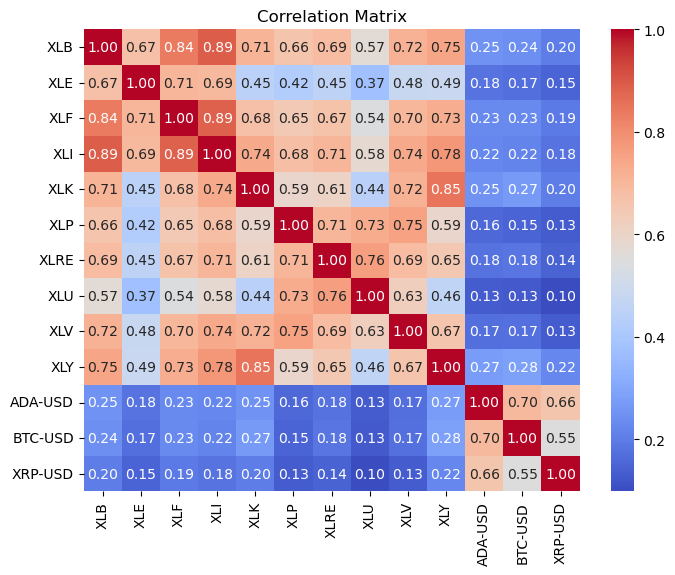

In [45]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(env.returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Training and Prediction

In [ ]:
WINDOW_FIT = 1700
WINDOW_HOLD = 400
N_ASSETS = len(env.returns.columns)
weights_equal, weights_minvar, weights_maxsharpe, weights_lstm = [], [], [], []
result_equal, result_minvar, result_maxsharpe, result_lstm = [], [], [], []


testing_period_returns = env.get_state(
    end=1300, 
    lookback=1300
    )

holding_period_returns = env.get_state(
    end= 1700, 
    lookback = 400
)

################## BENCHMARK MODELS

### 1. Equal weights
equal_weights = np.ones(N_ASSETS) / N_ASSETS

r = np.dot(holding_period_returns, equal_weights)
result_equal.append(r.tolist())
weights_equal.append(equal_weights)

### 2. Min variance
min_var_weights = minvar_method.get_optimal_weights(testing_period_returns)

r = np.dot(holding_period_returns, min_var_weights)
result_minvar.append(r.tolist())
weights_minvar.append(min_var_weights)

### 3. Max Sharpe
max_sharpe_weights = maxsharpe_method.get_optimal_weights(testing_period_returns)

r = np.dot(holding_period_returns, max_sharpe_weights)
result_maxsharpe.append(r.tolist())
weights_maxsharpe.append(max_sharpe_weights)


################## Price Predictors put here: aka LSTM and RL
prices = env.get_prices(
    end=1700, 
    lookback=1700
)
res, rmse_score, predicted_prices, actual_prices = LstmModel(filtered_data=prices, holding_period=WINDOW_HOLD)
predicted_returns = predicted_prices.pct_change().dropna() * 100
lstm_weights = maxsharpe_method.get_optimal_weights(predicted_returns)

r = np.dot(holding_period_returns, lstm_weights)
result_lstm.append(r.tolist())
weights_lstm.append(lstm_weights)

# CLEARED THE OUPUT HERE

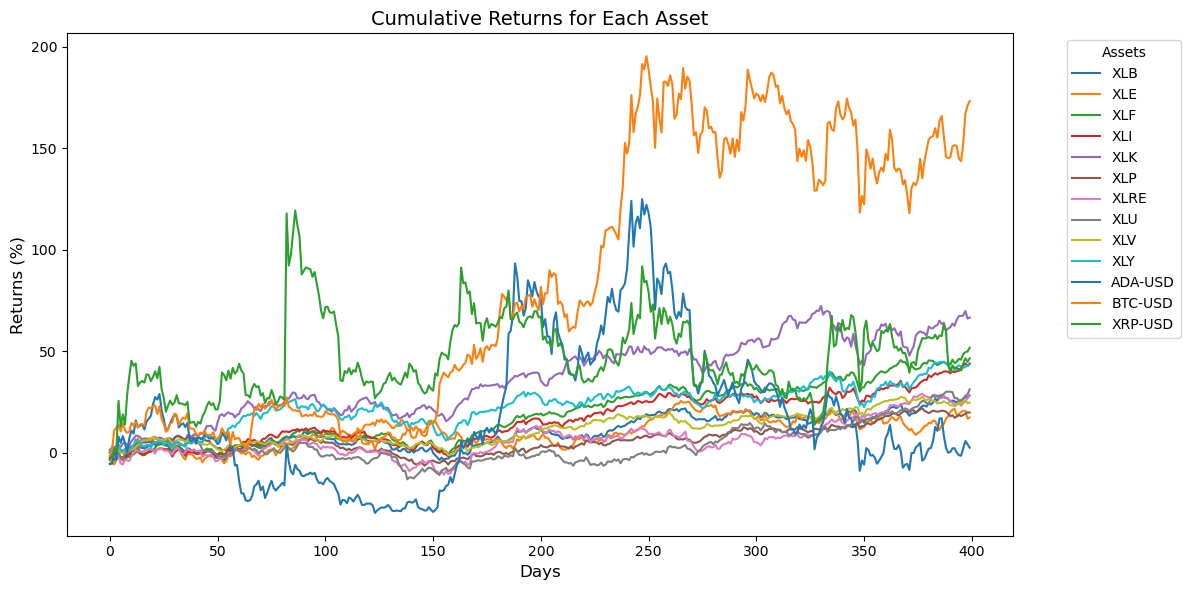

In [127]:
asset_list = env.prices.columns.to_list()

plt.figure(figsize=(12, 6))  # Create a figure for the plot
for stock in asset_list:
    cumulative_returns = cumulative_pct_change(holding_period_returns[stock])
    plt.plot(cumulative_returns, label=stock)  # Plot cumulative returns for the asset

# Add labels and title
plt.xlabel("Days", fontsize=12)
plt.ylabel("Returns (%)", fontsize=12)
plt.title("Cumulative Returns for Each Asset", fontsize=14)

# Add a legend
plt.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Evaluation

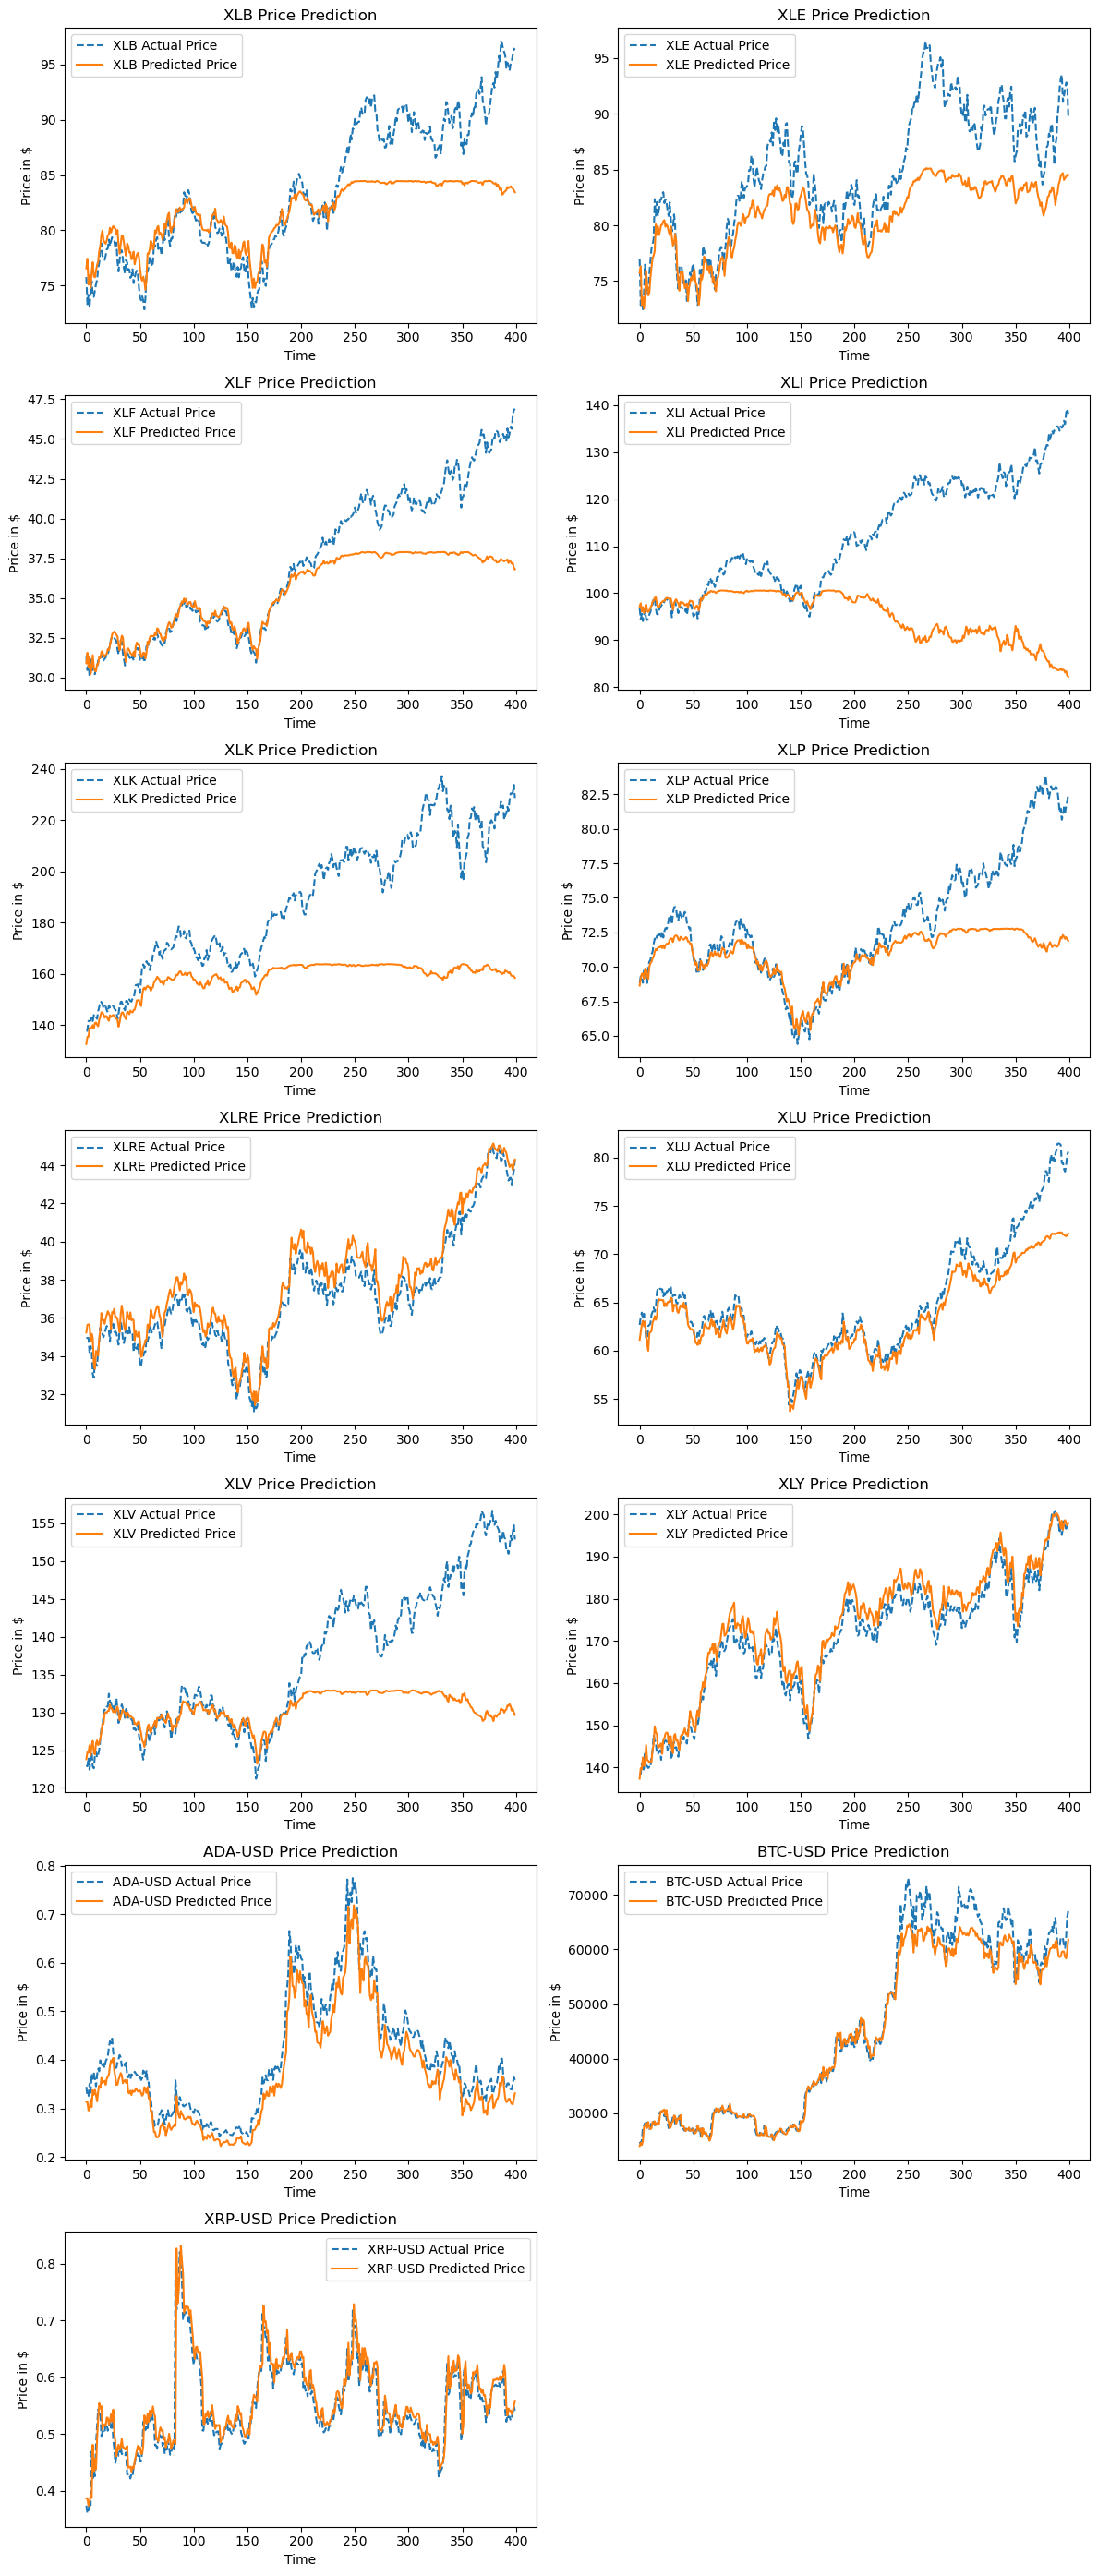

In [ ]:
num_stocks = len(asset_list)
num_cols = 2
num_rows = math.ceil(num_stocks / num_cols)

# Create subplots with the calculated rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))
axes = axes.flatten() 
for i, stock in enumerate(asset_list):
    ax = axes[i]  # Get the current subplot
    ax.plot(actual_prices[stock], label=f"{stock} Actual Price", linestyle='--')
    ax.plot(predicted_prices[stock], label=f"{stock} Predicted Price", linestyle='-')
    ax.set_title(f"{stock} Price Prediction")
    ax.set_xlabel('Time')
    ax.set_ylabel('Price in $')
    ax.legend()

for j in range(len(axes)):
    if j >= num_stocks:
        axes[j].axis('off')

plt.tight_layout()

In [111]:
rmse_score.to_csv("final_rmse_score.csv")

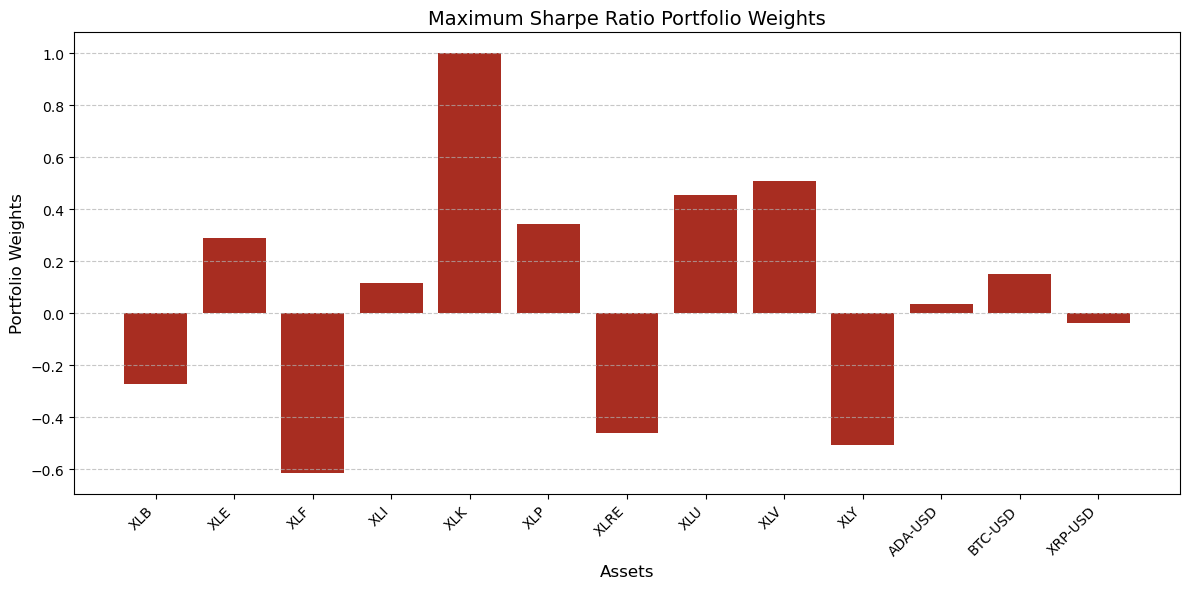

In [136]:
max_sharpe_ratio_color = '#a82d21'
plt.figure(figsize=(12, 6))
plt.bar(asset_list, weights_maxsharpe[0], color=max_sharpe_ratio_color)

# Add labels and title
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Portfolio Weights", fontsize=12)
plt.title("Maximum Sharpe Ratio Portfolio Weights", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

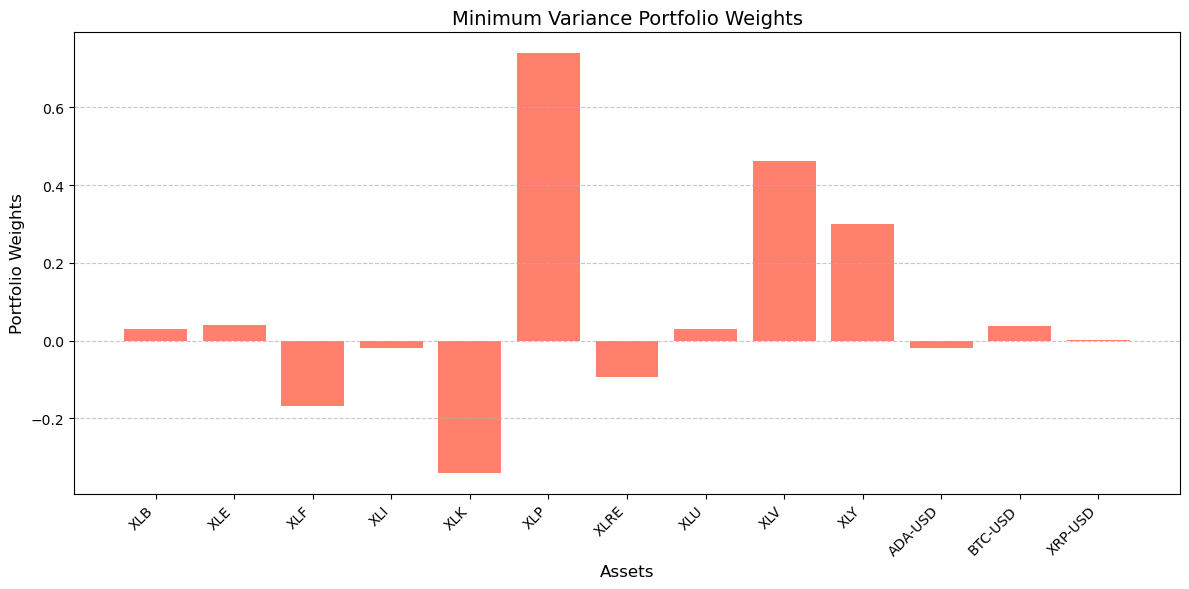

In [137]:
min_var_color = '#ff806c'
plt.figure(figsize=(12, 6))
plt.bar(asset_list, weights_minvar[0], color=min_var_color)

# Add labels and title
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Portfolio Weights", fontsize=12)
plt.title("Minimum Variance Portfolio Weights", fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

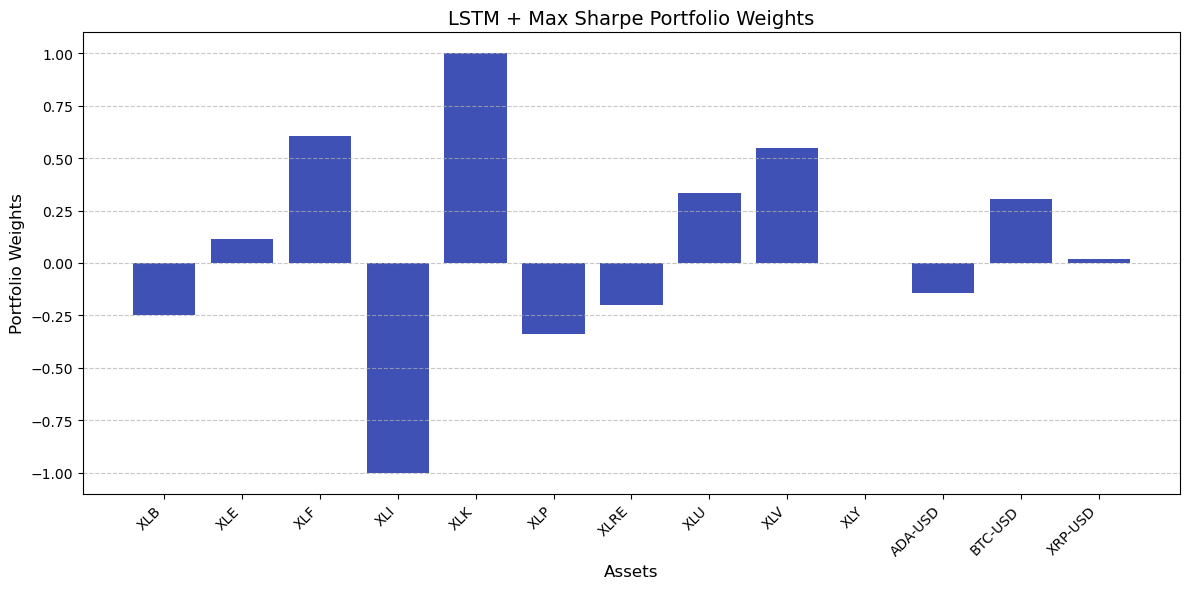

In [138]:
lstm_color = '#3f51b5'
plt.figure(figsize=(12, 6))
plt.bar(asset_list, weights_lstm[0], color=lstm_color)

# Add labels and title
plt.xlabel("Assets", fontsize=12)
plt.ylabel("Portfolio Weights", fontsize=12)
plt.title("LSTM + Max Sharpe Portfolio Weights", fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

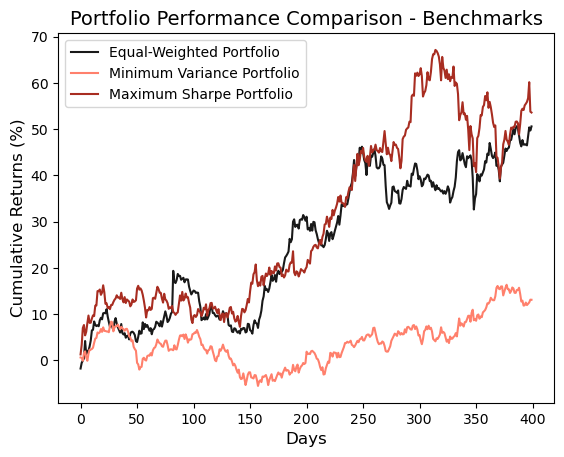

In [140]:
# flatten into list and compare results
equal_weights_daily_returns = [item for sublist in result_equal for item in sublist]
minvar_method_daily_returns = [item for sublist in result_minvar for item in sublist]
maxsharpe_method_daily_returns = [item for sublist in result_maxsharpe for item in sublist]
lstm_method_daily_returns = [item for sublist in result_lstm for item in sublist]

equal_weights_color = "#191919";

plt.figure()
plt.xlabel("Days", fontsize=12)
plt.ylabel("Returns (%)")
plt.plot(cumulative_pct_change(equal_weights_daily_returns), label = "Equal-Weighted Portfolio", color = equal_weights_color)
plt.plot(cumulative_pct_change(minvar_method_daily_returns), label = "Minimum Variance Portfolio", color = min_var_color)
plt.plot(cumulative_pct_change(maxsharpe_method_daily_returns), label = "Maximum Sharpe Portfolio", color =max_sharpe_ratio_color)
# plt.plot(cumulative_pct_change(lstm_method_daily_returns), label = "Lstm Model Portfolio")
plt.ylabel("Cumulative Returns (%)", fontsize=12)
plt.title("Portfolio Performance Comparison - Benchmarks", fontsize=14)
plt.legend(fontsize=10)
plt.show()


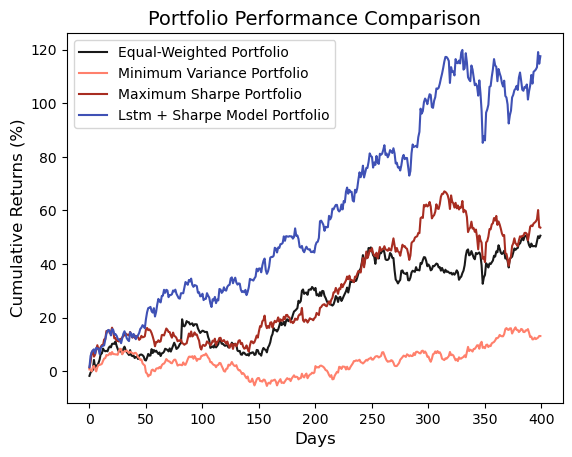

In [141]:
plt.figure()
plt.xlabel("Days", fontsize=12)
plt.ylabel("Returns (%)")
plt.plot(cumulative_pct_change(equal_weights_daily_returns), label = "Equal-Weighted Portfolio", color =equal_weights_color)
plt.plot(cumulative_pct_change(minvar_method_daily_returns), label = "Minimum Variance Portfolio", color =min_var_color)
plt.plot(cumulative_pct_change(maxsharpe_method_daily_returns), label = "Maximum Sharpe Portfolio", color =max_sharpe_ratio_color)
plt.plot(cumulative_pct_change(lstm_method_daily_returns), label = "Lstm + Sharpe Model Portfolio", color =lstm_color)
plt.ylabel("Cumulative Returns (%)", fontsize=12)
plt.title("Portfolio Performance Comparison", fontsize=14)
plt.legend(fontsize=10)
plt.show()

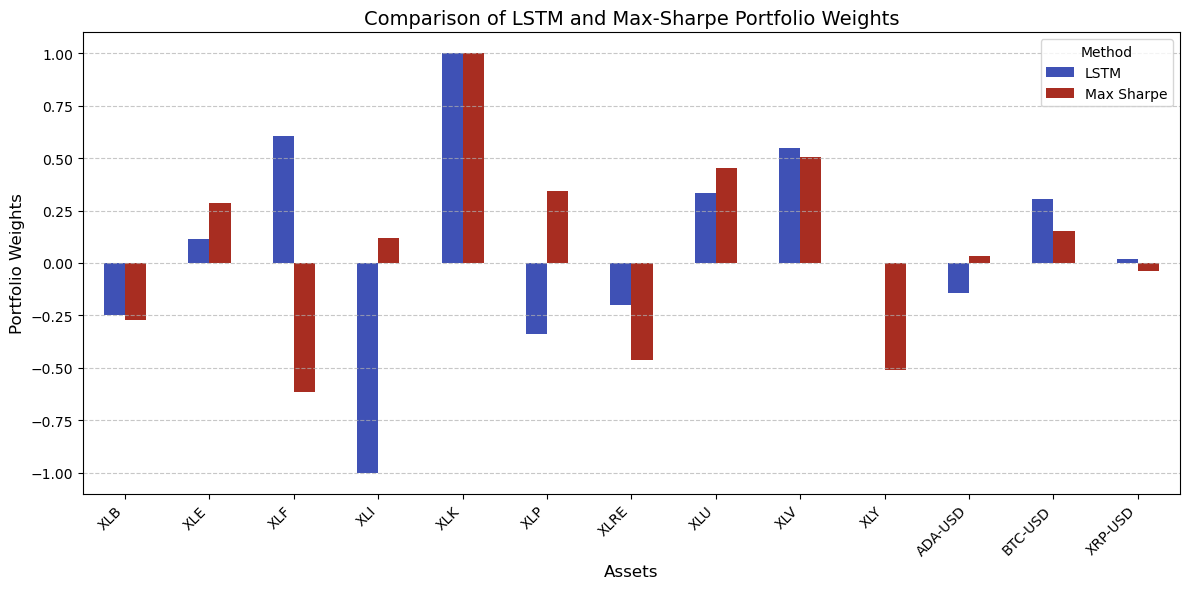

In [ ]:
weights_lstm
weights_maxsharpe

new_dict = {}

for i, stock in enumerate(asset_list):
    new_dict.update({
        stock: {
            "LSTM": weights_lstm[0][i],
            "Max Sharpe": weights_maxsharpe[0][i]
        }
    })

compiled = pd.DataFrame(new_dict)
compiled = compiled.transpose()

compiled.plot(kind='bar', figsize=(12, 6), color=[lstm_color, max_sharpe_ratio_color])

# Add labels and title
plt.xlabel('Assets', fontsize=12)
plt.ylabel('Portfolio Weights', fontsize=12)
plt.title('Comparison of LSTM and Max-Sharpe Portfolio Weights', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title="Method", loc='best')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
results = []

equal_weights_stats = get_stats(equal_weights_daily_returns)
equal_weights_stats["Name"] = "Equal Weights Portfolio"
results.append(equal_weights_stats)

minvar_method_stats = get_stats(minvar_method_daily_returns)
minvar_method_stats["Name"] = "Minimum Variance Portfolio"
results.append(minvar_method_stats)

maxsharpe_method_stats = get_stats(maxsharpe_method_daily_returns)
maxsharpe_method_stats["Name"] = "Maximum Sharpe Portfolio"
results.append(maxsharpe_method_stats)

lstm_model_stats = get_stats(lstm_method_daily_returns)
lstm_model_stats["Name"] = "Lstm Model Portfolio"
results.append(lstm_model_stats)


stats = pd.DataFrame(results).set_index("Name")
stats

,Cumulative Return,Sharpe Ratio,Maximum Drawdown,Value at Risk
Name,,,,
Equal Weights Portfolio,50.574080,0.098418,0.648121,1.421402
Minimum Variance Portfolio,13.111975,0.045101,1.641540,1.188920
Maximum Sharpe Portfolio,53.583446,0.094130,0.491887,1.712336
Lstm Model Portfolio,117.557013,0.148528,0.311463,1.918467


In [133]:
stats.index.to_list()
plt.bar(stats["Cumulative Return"])

TypeError: bar() missing 1 required positional argument: 'height'

Text(0.5, 1.0, 'Final Cumulative Returns for Benchmarks and LSTM Model')

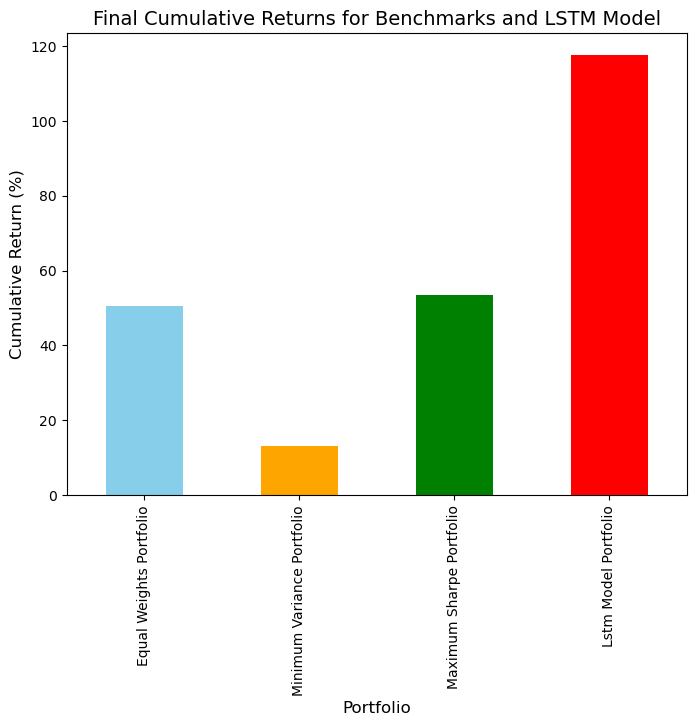

In [135]:
stats["Cumulative Return"].plot(kind='bar', figsize=(8, 6), color=['skyblue', 'orange', 'green', 'red'])

# Add labels and title
plt.xlabel('Portfolio', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.title('Final Cumulative Returns for Benchmarks and LSTM Model', fontsize=14)
